In [1]:
from matplotlib.pyplot import *
import numpy as np
from matplotlib import *
import h5py
from matplotlib import cm
from tqdm import tqdm
import pandas as pd
import sklearn
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import cv2 as cv

In [2]:
# load images
import rawpy
names = ["1.dng", "2.dng", "3.dng"]
spectrums = []
spectrums_bw = []
for n in names:
    spectrums.append(rawpy.imread(n).postprocess())
    spectrums_bw.append(cv.cvtColor(rawpy.imread(n).postprocess(), cv.COLOR_BGR2GRAY))
spectrums = np.array(spectrums)
spectrums_bw = np.array(spectrums_bw)

In [3]:
spectrums.shape

(3, 3072, 4096, 3)

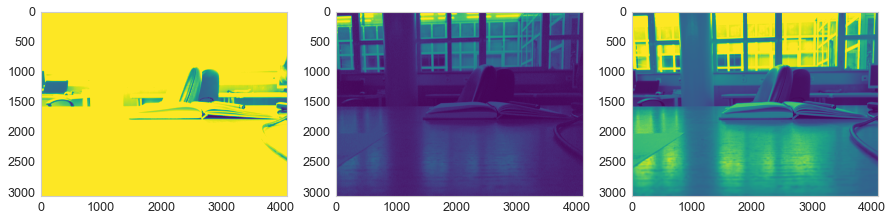

In [4]:
fig, ax = subplots(1, 3, figsize = (15, 5))

axs = ax[0]
axs.imshow(spectrums_bw[0])
axs.grid(False)

axs = ax[1]
axs.imshow(spectrums_bw[1])
axs.grid(False)

axs = ax[2]
axs.imshow(spectrums_bw[2])
axs.grid(False)

In [5]:
min_max_scaled = np.array([ (spectrums[i, :, :] - spectrums[i, :, :].min(axis = (0, 1)))/(spectrums[i, :, :].max(axis = (0, 1)) - spectrums[i, :, :].min(axis = (0, 1))) 
                               for i in range(spectrums_bw.shape[0])])

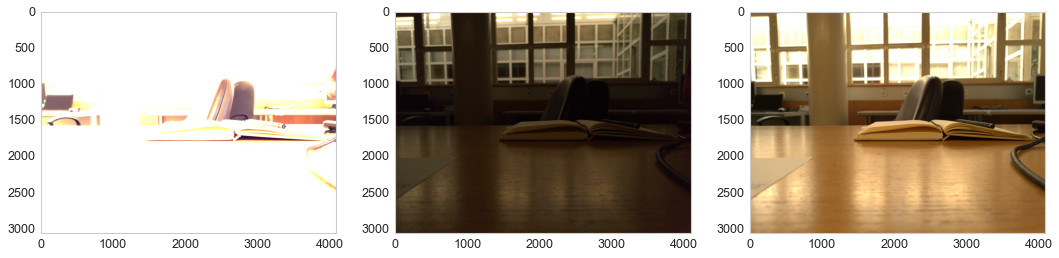

In [9]:
fig, ax = subplots(1, 3, figsize = (18, 8))

axs = ax[0]
axs.imshow(min_max_scaled[0])
axs.grid(False)

axs = ax[1]
axs.imshow(min_max_scaled[1])
axs.grid(False)

axs = ax[2]
axs.imshow(min_max_scaled[2])
axs.grid(False)


In [5]:
def gauss(x, sigma, val):
    return np.exp( - (x - val)**2 / (2 * sigma ** 2))

In [6]:
w_exposedness = gauss(min_max_scaled[:, :, :, 0], 0.2, 0.5) * gauss(min_max_scaled[:, :, :, 1], 0.2, 0.5) * gauss(min_max_scaled[:, :, :, 2], 0.2, 0.5)

new_data = np.zeros(spectrums.shape[1:])
norm_weigths = np.zeros(w_exposedness.shape)

for i in tqdm(range(w_exposedness.shape[1])):
    for j in range(w_exposedness.shape[2]):
        sum = np.sum(w_exposedness[:, i, j])
        norm_weigths[:, i, j] = w_exposedness[:, i, j]/sum
        new_data[i, j] = (spectrums[0, i, j, :]*w_exposedness[0, i, j]/sum + 
                                spectrums[1, i, j, :]*w_exposedness[1, i, j]/sum + 
                                spectrums[2, i, j, :]*w_exposedness[2, i, j]/sum)

100%|██████████| 3072/3072 [06:12<00:00,  8.24it/s]


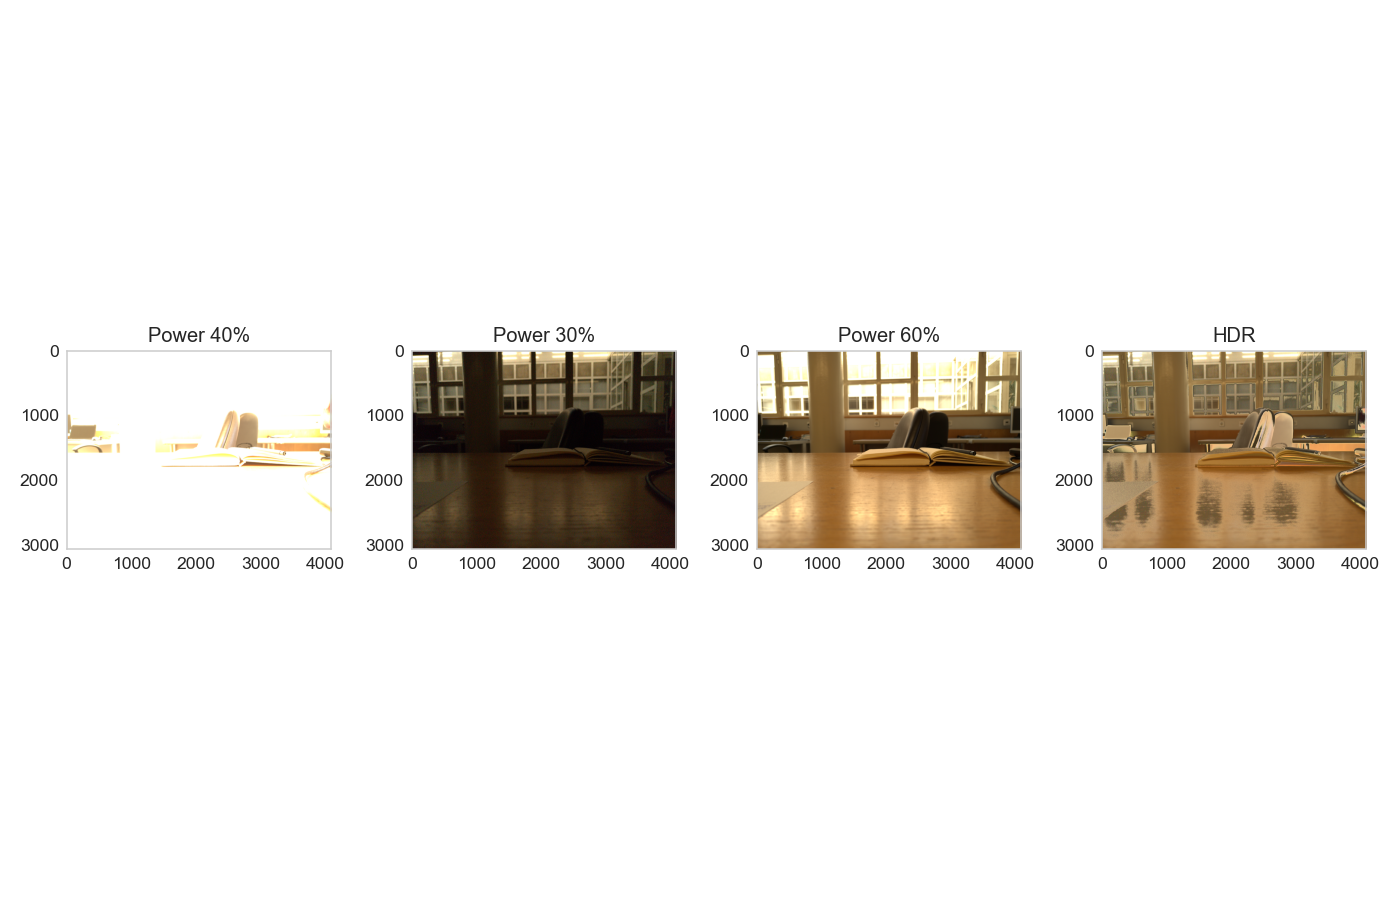

In [8]:
%matplotlib widget
fig, ax = subplots(1, 4, figsize = (14, 9))

wl = [509, 464, 490, 705]

axs = ax[0]
axs.set_title('Power 40%')
axs.imshow(spectrums[0])
axs.grid(False)

axs = ax[1]
axs.set_title('Power 30%')
axs.imshow(spectrums[1])
axs.grid(False)

axs = ax[2]
axs.set_title('Power 60%')
axs.imshow(spectrums[2])
axs.grid(False)

axs = ax[3]
axs.set_title('HDR')
axs.imshow(np.array(new_data, dtype = int))
axs.grid(False)

fig.tight_layout()

In [7]:
from scipy.ndimage import convolve

kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6], [4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

def add_padding(data, x_pad, y_pad):
    return np.pad(data, ((x_pad, x_pad), (y_pad, y_pad), (0,0)), mode = 'mean')

def downscale(image):
    image_blur = convolve(image, kernel, mode = 'constant')
    return image_blur[::2, ::2]

def upscale(image):
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    image_up[::2, ::2] = image
    return convolve(image_up, 4*kernel, mode = 'constant')

def laplacian_pyramid(image, layers):
    laplace_pyra = []
    for energy in range(image.shape[0]):
        im1 = image[energy]
        lap_pyra = []
        for layer in range(layers):
            down = downscale(im1)
            up = upscale(down)
            lap_pyra.append(im1 - up)
            im1 = down
        lap_pyra.append(down)
        laplace_pyra.append(lap_pyra)
    return np.array(laplace_pyra, dtype = object)

def gaussian_pyramid(mask, layers):
    gaussian_pyra = []
    for energy in range(mask.shape[0]):
        im1 = mask[energy]
        gauss_pyra = [im1]
        for layer in range(0, layers):
            im1 = downscale(im1)
            gauss_pyra.append(im1)
        gaussian_pyra.append(gauss_pyra)
    return np.array(gaussian_pyra, dtype = object)

def final_pyramid(L, G):
    laplacian_final = []
    for i in range(L.shape[1]):
        laplacian_final.append((L[0, i]*G[0, i] + L[1, i]*G[1, i] + L[2, i]*G[2, i]))
    return np.array(laplacian_final, dtype = object)

def get_image(final_pyramid):
    rev_pyramid = final_pyramid[::-1]
    im = rev_pyramid[0]
    for i in range(1, len(rev_pyramid)):
        im = upscale(im) + rev_pyramid[i]
    return im

In [72]:
new_data1 = np.zeros(spectrums.shape[1:])
n_layers = 10

weights_p = norm_weigths
# weights_p = selective
G = gaussian_pyramid(weights_p, layers = n_layers)
for j in tqdm(range(3)):
    image_p = spectrums[:, :, :, j]
    L = laplacian_pyramid(image_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1[:, :, j] = pyra_image

100%|██████████| 3/3 [00:12<00:00,  4.15s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

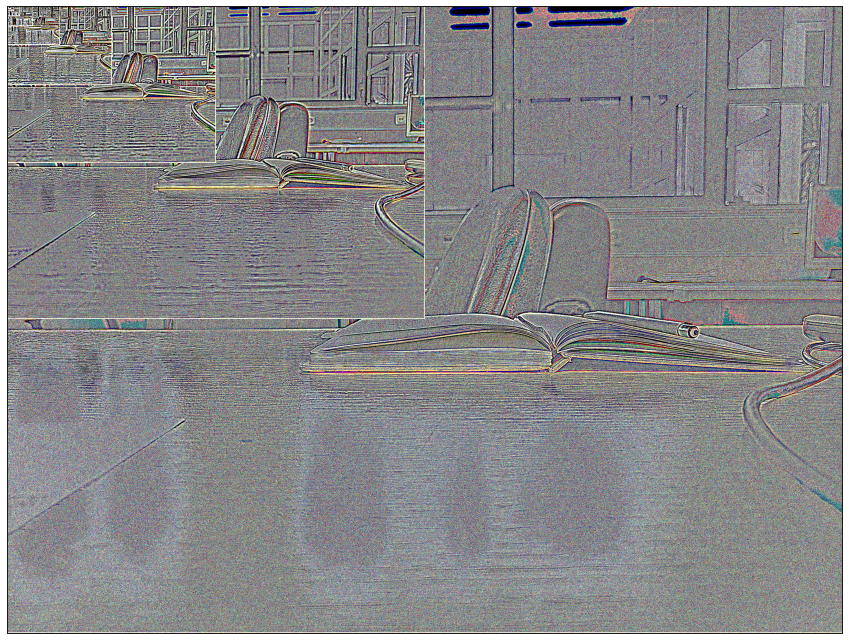

In [70]:
%matplotlib inline
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['axes.edgecolor'] = '0.1'
fig, ax = subplots(3, 1, figsize = (14, 9))

im = 0
axs = ax[im]
for i in range(0, L.shape[1]):
    axs.imshow(G[im, i], cmap = 'gray', origin = 'lower')
    
axs.set_xlim(0, spectrums.shape[2])
axs.set_ylim(spectrums.shape[1], 0)
axs.set_xticks([])
axs.set_yticks([])

axs.grid(False)

im = 1
axs = ax[im]
for i in range(0, L.shape[1]):
    axs.imshow(G[im, i], cmap = 'gray', origin = 'lower')
axs.set_xlim(0, spectrums.shape[2])
axs.set_ylim(spectrums.shape[1], 0)
axs.set_xticks([])
axs.set_yticks([])
axs.grid(False)

im = 2
axs = ax[im]
for i in range(0, L.shape[1]):
    axs.imshow(G[im, i], cmap = 'gray', origin = 'lower')
axs.set_xlim(0, spectrums.shape[2])
axs.set_ylim(spectrums.shape[1], 0)
axs.set_xticks([])
axs.set_yticks([])
axs.grid(False)

fig.tight_layout()
# fig.savefig('gaussian.jpg', dpi = 300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


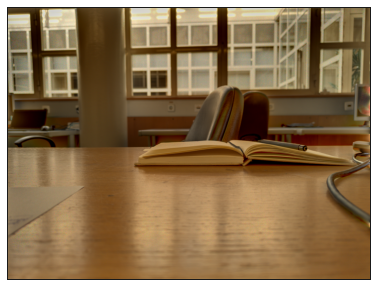

In [76]:
fig, axs = subplots(figsize = (10 ,5))
axs.imshow(np.array(new_data1, dtype = int))
axs.set_xlim(0, spectrums.shape[2])
axs.set_ylim(spectrums.shape[1], 0)
axs.set_xticks([])
axs.set_yticks([])

axs.grid(False)
# fig.savefig('final.jpg', dpi = 300)


In [304]:
import numpy as np
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import imageio
from PIL import Image

# create a  Binomial (5-tap) filter
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6], [4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

def interpolate(image):
    """
    Interpolates an image with upsampling rate r=2.
    """
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    image_up[::2, ::2] = image
    return ndimage.filters.convolve(image_up,4*kernel, mode='constant')
                                
def decimate(image):
    """
    Decimates an image with downsampling rate r=2.
    """
    image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
    return image_blur[::2, ::2]                                
               
                                      
  # here is the constructions of pyramids
def pyramids(image):
    """
    Constructs Gaussian and Laplacian pyramids.
    Parameters :
    image  : the original image (i.e. base of the pyramid)
    Returns :
    G   : the Gaussian pyramid
    L   : the Laplacian pyramid
    """
    G = [image, ]
    L = []

    while image.shape[0] >= 96 and image.shape[1] >= 96:
        image = decimate(image)
        G.append(image)
    for i in range(len(G) - 1):
        L.append(G[i] - interpolate(G[i + 1]))

    return G[:-1], L


def pyramidBlending(A, B, mask):
    [GA, LA] = pyramids(A)
    [GB ,LB] = pyramids(B)
    [Gmask, LMask] = pyramids(mask)
    blend = []
    for i in range(len(LA)):
        LS = Gmask[i]/255*LA[i] + (1-Gmask[i]/255)*LB[i]
        blend.append(LS)
    return blend

# reconstruct the pyramids as well as upsampling and add up with each level
def reconstruct(pyramid):
    revPyramid = pyramid[::-1]
    stack = revPyramid[0]
    for i in range(1, len(revPyramid)):
        stack = interpolate(stack) + revPyramid[i]
    return stack

def colorBlending(img1, img2, mask):
    img1R,img1G,img1B = cv2.split(img1)
    img2R,img2G,img2B = cv2.split(img2)
    R = reconstruct(pyramidBlending(img1R, img2R, mask))
    G = reconstruct(pyramidBlending(img1G, img2G, mask))
    B = reconstruct(pyramidBlending(img1B, img2B, mask))
    output = cv2.merge((R, G, B))
    return output

In [305]:
image_git = colorBlending(spectrums[0, :, :], spectrums[2, :, :], np.zeros((3072, 4096))+0.5)

C:\Users\tomas\AppData\Local\Temp\ipykernel_19512\3002420090.py:25: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
C:\Users\tomas\AppData\Local\Temp\ipykernel_19512\3002420090.py:19: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  return ndimage.filters.convolve(image_up,4*kernel, mode='constant')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


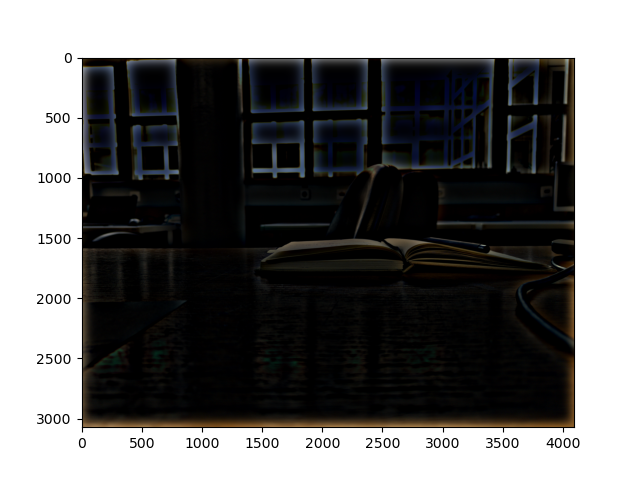

In [306]:
subplots()
imshow(np.array(image_git, dtype = int))